# **Customer Segmentation with K-Means Clustering based on RFM Model**

## **Table of Contents**
 1. [Introduction](#Introduction) <br>
 2. [Data Understanding](#Data-Understanding) <br>
 3. [Data Pre-processing](#Data-Pre-processing) <br>
 4. [Exploratory Data Analysis](#Exploratory-Data-Analysis) <br>
 5. [RFM Analysis](#RFM-Analysis) <br>
 6. [K-Means Clustering on RFM Values](#K-Means-Clustering-on-RFM-Values) <br>
 7. [Results](#Results) <br>
 8. [Conclusion](#Conclusion) <br>
 9. [Recommendations](#Recommendations) <br>

## **Introduction**

This project purpose to divide customers into segments based on K-Means Clustering, which represent best marketing strategies according to the customer sales behavior, characteristics, and needs.

## **Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.mplot3d import Axes3D

## **Dataset**

The dataset obtained from database of Schneider Electric retail, contains all the transactions occurring between 01/12/2010 and 09/12/2018 for Central Asia customers.The company mainly sells electrical systems, automation and switches. Many customers of the company are distrubitors, system integrators and design companies. It can be found here and the attributes are as follows.

**InvoiceNo:** Invoice number, a 6-digit integral number uniquely assigned to each transaction.<br>
**StockCode:** Product (item) code, a 5-digit integral number uniquely assigned to each distinct product.<br>
**Description:** Product (item) name. <br>
**Quantity:** The quantities of each product (item) per transaction<br>
**InvoiceDate:** Invice Date and time, the day and time when each transaction was generated.<br>
**UnitPrice:** Unit price, Product price per unit in sterling.<br>
**CustomerID:** Customer number, a 5-digit integral number uniquely assigned to each customer.<br>
**Country:** Country name, the name of the country where each customer resides.<br>

In [3]:
#reading the "Online_Retail" dataset
df=pd.read_excel("/content/Online Retail.xlsx")

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,Invoice date,UnitPrice,Price (EURO),CustomerID,Country
0,456371,XB5AD33,ПЕРЕКЛЮЧАТЕЛЬ,80,2010-12-01,25.5,2040.0,13748,Kazakhstan
1,456372,XB7EA31P,КНОПКА ЗЕЛ. НО,6,2010-12-02,18.5,111.0,17850,Kazakhstan
2,456372,XACA2713,ПОДВЕСНАЯ СТАНЦИЯ 2 КНОПКИ+АВАР.ОСТАНОВ,6,2010-12-03,18.5,111.0,17850,Kazakhstan
3,456373,RHK412B,РЕЛЕ БИСТАБИЛЬНОЕ 24В =,6,2010-12-04,25.5,153.0,17850,Kazakhstan
4,456373,RHZ42,ОСНОВА ДЛЯ Ф. МОДУЛЯ,6,2010-12-05,33.9,203.4,17850,Kazakhstan


In [5]:
#exploring the data types of columns and the number of entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10574 entries, 0 to 10573
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   InvoiceNo     10574 non-null  object        
 1   StockCode     10574 non-null  object        
 2   Description   10574 non-null  object        
 3   Quantity      10574 non-null  int64         
 4   Invoice date  10574 non-null  datetime64[ns]
 5   UnitPrice     10574 non-null  float64       
 6   Price (EURO)  10574 non-null  float64       
 7   CustomerID    10574 non-null  int64         
 8   Country       10574 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 743.6+ KB


The dataset comprises 541909 rows and 8 columns. The data types of columns are proper to the description of columns, so there is no need to make any type and format changes.

## **Data Pre-processing**

#### **Missing Value Handling**

In [6]:
#checking how many missing values do we have
df.isnull().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
Invoice date    0
UnitPrice       0
Price (EURO)    0
CustomerID      0
Country         0
dtype: int64

As it is seen, there are missing values in the columns "Description" and "CustomerID". The "Description" column will not be included in further analysis, so we will handle the missing values in the "CustomerID" column by dropping the records for retail data customer segmentation."

In [7]:
#dropping Null records
df.dropna(subset='CustomerID',inplace=True)

In [8]:
df['CustomerID'].isnull().sum()

0

In [9]:
df.shape

(10574, 9)

Great! We're done with the missing values.

#### **Adding New Attribute "Sales" to the Dataset**

In [10]:
#creating a column to calculate total sales value for each transaction
df['Sales'] = round(df['Quantity'] * df['UnitPrice'],2)

#### **Excluding return transactions**

In [11]:
#removing the negative transactions which mean return goods
df_retail=df[df["Sales"]>0]

In [12]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,Invoice date,UnitPrice,Price (EURO),CustomerID,Country,Sales
0,456371,XB5AD33,ПЕРЕКЛЮЧАТЕЛЬ,80,2010-12-01,25.5,2040.0,13748,Kazakhstan,2040.0
1,456372,XB7EA31P,КНОПКА ЗЕЛ. НО,6,2010-12-02,18.5,111.0,17850,Kazakhstan,111.0
2,456372,XACA2713,ПОДВЕСНАЯ СТАНЦИЯ 2 КНОПКИ+АВАР.ОСТАНОВ,6,2010-12-03,18.5,111.0,17850,Kazakhstan,111.0
3,456373,RHK412B,РЕЛЕ БИСТАБИЛЬНОЕ 24В =,6,2010-12-04,25.5,153.0,17850,Kazakhstan,153.0
4,456373,RHZ42,ОСНОВА ДЛЯ Ф. МОДУЛЯ,6,2010-12-05,33.9,203.4,17850,Kazakhstan,203.4


In [13]:
df_retail.shape

(10445, 10)

#### **Reformatting column "InvoiceDate"**

In [20]:
# Extract day, month and year from InvoiceDate column into a new column InvoiceDay
df_retail['InvoiceDay'] = df_retail["Invoice date"].apply(lambda x: datetime(x.year, x.month, x.day))

<ipython-input-20-3b2516819568>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retail['InvoiceDay'] = df_retail["Invoice date"].apply(lambda x: datetime(x.year, x.month, x.day))


In [21]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,Invoice date,UnitPrice,Price (EURO),CustomerID,Country,Sales,InvoiceDay
0,456371,XB5AD33,ПЕРЕКЛЮЧАТЕЛЬ,80,2010-12-01,25.5,2040.0,13748,Kazakhstan,2040.0,2010-12-01
1,456372,XB7EA31P,КНОПКА ЗЕЛ. НО,6,2010-12-02,18.5,111.0,17850,Kazakhstan,111.0,2010-12-02
2,456372,XACA2713,ПОДВЕСНАЯ СТАНЦИЯ 2 КНОПКИ+АВАР.ОСТАНОВ,6,2010-12-03,18.5,111.0,17850,Kazakhstan,111.0,2010-12-03
3,456373,RHK412B,РЕЛЕ БИСТАБИЛЬНОЕ 24В =,6,2010-12-04,25.5,153.0,17850,Kazakhstan,153.0,2010-12-04
4,456373,RHZ42,ОСНОВА ДЛЯ Ф. МОДУЛЯ,6,2010-12-05,33.9,203.4,17850,Kazakhstan,203.4,2010-12-05


We're all set. Now, Let's jump into it!

## **Exploratory Data Analysis**

#### **Descriptive Statistics**

In [22]:
df_retail[["Quantity","UnitPrice"]].describe()

,Quantity,UnitPrice
count,10445.000000,10445.000000
mean,8.240785,40.193001
std,42.642805,163.642101
min,1.000000,1.000000
25%,1.000000,12.800000
50%,2.000000,25.100000
75%,6.000000,42.500000
max,2880.000000,8875.200000


#### **What is the number of unique Customers, Stock Code, Description, Invoice No, and Invoice Date ?**

In [23]:
#finding unique numbers of attributes
df_retail.nunique()

InvoiceNo        399
StockCode       3240
Description      619
Quantity          84
Invoice date    2934
UnitPrice        152
Price (EURO)     776
CustomerID       284
Country            5
Sales            769
InvoiceDay      2934
dtype: int64

We get a convenient result except for the number of StockCode and Description, which do not match each other. StockCode uniquely identifies the description of a product. In that sense, they should be equal to each other. Let's find the reason behind it.

In [24]:
#finding out the StokCodes which have more than 1 Description
df_unique=df_retail.groupby(["StockCode"]).nunique().reset_index()
df_unique=df_unique[df_unique["Description"]>1][["StockCode","Description"]].sort_values(by=["Description"],ascending=False)
df_unique.head()

,StockCode,Description
4,AZ5DE0255,83
3,AZ5DE0151,83
2,AZ5DE0071,82
110,K1I023QCH,81
2509,XB7ES545P,81


In [25]:
#selecting one of the StockCodes to analyze in detailed
df_retail[df_retail["StockCode"]==23231]["Description"].unique()

array([], dtype=object)

As a result, the discrepancy in the "Description" column won't affect our RFM analysis and can be left as it is.

#### **How many orders were cancelled ?**

In [26]:
#finding the percentage of cancelled orders
cancelled_orders=df[df["Sales"]<0]["InvoiceNo"].nunique()
total_orders=df["InvoiceNo"].nunique()
print("Number of cancelled orders :", cancelled_orders)
print("Percentage of cancelled orders : {:.2f}%".format(cancelled_orders/total_orders*100))

Number of cancelled orders : 41
Percentage of cancelled orders : 8.47%


It is a better approach to elaborate on the reason behind the cancellation of orders to provide leveraged services.

#### **What are the top 5 countries with the highest Sales ?**

In [27]:
df_top=df_retail.groupby(by=["Country"])
df_top=df_top.agg({"Sales":["sum"]})
df_top.columns = df_top.columns.droplevel(1)
df_top.sort_values(by=['Sales'],ascending=False,inplace=True)
df_top=df_top.reset_index().head(10)
df_top

,Country,Sales
0,Kazakhstan,1819989.8
1,Kyrgistan,19860.1
2,Uzbekistan,11381.8
3,Azerbaijan,7823.0
4,Tadjikistan,1996.5


<ipython-input-28-49c8f9c6c4f0>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")


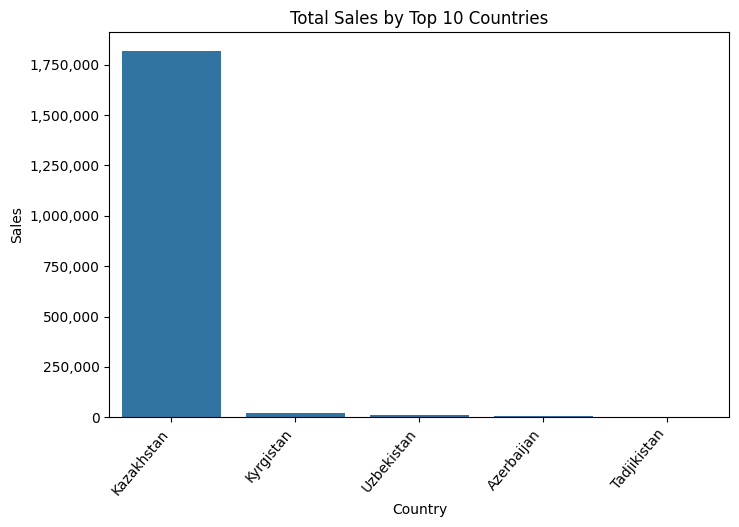

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
ax=sns.barplot(x='Country', y='Sales', data=df_top, estimator=max, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Total Sales by Top 5 Countries")
plt.show()

Unsurprisingly, as a UK-based online retail company, the United Kingdom is a leader in terms of total sales.

#### **What are the top 5 countries with the highest number of customers ?**

In [29]:
df_top=df_retail.groupby(by=["Country"])["CustomerID"].nunique()
df_top=df_top.sort_values(ascending=False).head(10)
df_top


Country
Kazakhstan     271
Kyrgistan        6
Uzbekistan       4
Azerbaijan       2
Tadjikistan      1
Name: CustomerID, dtype: int64

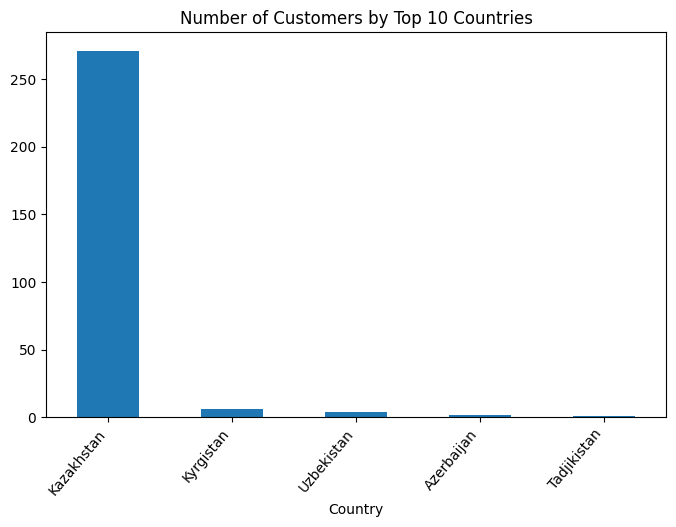

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
df_top.plot(kind="bar",x="Country")
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.title("Number of Customers by Top 5 Countries")
plt.show()

Similarly, the United Kingdom has the highest number of customers compared to the other countries.

We are ready to continue with RFM Analysis !

## **RFM Analysis**

The first thing we are going to do is to start with **RFM (Recency, Frequency, Monetary) Analysis** , which is a customer segmentation technique for analyzing customer value based on past buying behavior and then combine our results with **K-Means Clustering Algorithm.**

#### **Feature Engineering**

The next question is what are the metrics for RFM Analysis? RFM Analysis stands for Recency, Frequency, and Monetary Analysis, and their descriptions of them are given as follows.

**• Recency:** The time since last order with the product of customers.

**• Frequency:** The total number of transaction  between the customer’s invoice date and reference day.

**• Monetary:** The total transaction value of customers.

In [31]:
#finding the last invoice day + 1 in a new variable to calculate Recency
reference_day=df_retail["InvoiceDay"].max()+timedelta(1)

In [32]:
# calculating RFM values for each transaction and save them in a new dataframe "rfm"
rfm = df_retail.groupby('CustomerID').agg({
    'InvoiceDay' : lambda x: (reference_day - x.max()).days,
    'InvoiceNo' : 'count',
    'Sales' : 'sum'})
# rename the columns
rfm.rename(columns = {'InvoiceDay' : 'Recency',
                      'InvoiceNo' : 'Frequency',
                      'Sales' : 'Monetary'}, inplace = True)

rfm.head(6)

,Recency,Frequency,Monetary
CustomerID,,,
12747,2904,7,3585.6
12748,516,196,9756.0
12838,2307,59,3907.9
12841,1101,47,5059.9
12855,285,3,381.0
12868,1906,12,2033.0


Here is the result table of RFM values for each customer. Now, we are going to divide customers into segments based on RFM quartiles.

#### **Customer Segmentation based on RFM Quartiles**

In [33]:
#finding quantiles of RFM attributes
quantiles=rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,745.25,9.0,1847.250
0.50,1665.00,16.0,2967.100
0.75,2353.25,31.0,4331.125


In [34]:
#assigning Recency Score from 1 to 4 to the customers
def rec_score(x):
    if x<=18:
        return 4
    elif x<=51:
        return 3
    elif x<=142.75:
        return 2
    else:
        return 1

In [35]:
#assigning Frequency Score from 1 to 4 to the customers
def freq_score(x):
     if x<=17:
        return 1
     elif x<=41:
        return 2
     elif x<=100:
        return 3
     else:
        return 4

In [36]:
#assigning Monetary Score from 1 to 4 to the customers
def mon_score(x):
      if x<=307.415:
        return 1
      elif x<=674.485:
        return 2
      elif x<=1661.74:
        return 3
      else:
        return 4

In [37]:
#create segmentation table
rfm_segmentation=rfm.copy()
rfm_segmentation["R"]=rfm_segmentation["Recency"].apply(rec_score)
rfm_segmentation["F"]=rfm_segmentation["Frequency"].apply(freq_score)
rfm_segmentation["M"]=rfm_segmentation["Monetary"].apply(mon_score)

In [38]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12747,2904,7,3585.6,1,1,4
12748,516,196,9756.0,1,4,4
12838,2307,59,3907.9,1,3,4
12841,1101,47,5059.9,1,3,4
12855,285,3,381.0,1,1,2


What will happen next is we will find RFM segments and total scores to allocate the RFM groups.

In [39]:
# Concatenate & sum up the three columns
rfm_segmentation['RFM_Segment'] = rfm_segmentation["R"].map(str) + rfm_segmentation["F"].map(str) + rfm_segmentation["M"].map(str)
rfm_segmentation["RFM_Score"] = rfm_segmentation[['R', 'F', 'M']].sum(axis = 1)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2904,7,3585.6,1,1,4,114,6
12748,516,196,9756.0,1,4,4,144,9
12838,2307,59,3907.9,1,3,4,134,8
12841,1101,47,5059.9,1,3,4,134,8
12855,285,3,381.0,1,1,2,112,4


Now, it is time to end up with RFM groups. We will select 4 group names which are High Value, Loyal, At risk and Lost.

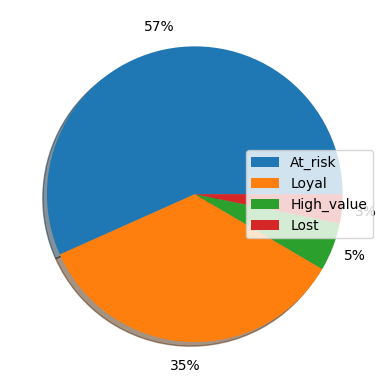

In [54]:
#the distribution of RFM Groups
rfm_pie=rfm_segmentation["RFM_Group"].value_counts()
plt.pie(rfm_pie,autopct="%1.0f%%",labels=None,pctdistance=1.16,shadow=True)
plt.legend(rfm_pie.index,loc="right")

In [58]:
# Assigning RFM Groups based on RFM score
# rfm_labels=['Lost', 'At_risk', 'Loyal', 'High_value']
# rfm_groups=pd.qcut(rfm_segmentation["RFM_Score"],q=4,labels=rfm_labels, duplicates='drop')
# rfm_segmentation["RFM_Group"]=rfm_groups.values
# rfm_segmentation.head()

# Assigning RFM Groups based on RFM score
rfm_labels = ['Lost', 'At_risk', 'Loyal', 'High_value']

# Define bin edges manually based on the distribution of RFM scores
# Adjust the edges based on your data distribution
bin_edges = [rfm_segmentation["RFM_Score"].min(), 4, 6, 8, rfm_segmentation["RFM_Score"].max()]

# Using cut to categorize the RFM scores into the defined bins
rfm_groups = pd.cut(rfm_segmentation["RFM_Score"], bins=bin_edges, labels=rfm_labels, include_lowest=True)
rfm_segmentation["RFM_Group"] = rfm_groups.values

# Display the head of the dataframe
print(rfm_segmentation.head())



            Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
CustomerID                                                                 
12747          2904          7    3585.6  1  1  4         114          6   
12748           516        196    9756.0  1  4  4         144          9   
12838          2307         59    3907.9  1  3  4         134          8   
12841          1101         47    5059.9  1  3  4         134          8   
12855           285          3     381.0  1  1  2         112          4   

            K_Cluster   RFM_Group  
CustomerID                         
12747               0     At_risk  
12748               2  High_value  
12838               2       Loyal  
12841               2       Loyal  
12855               0        Lost  


Lost and loyal customers make up 38% of the customer base. We can develop distinct campaigns for each targeted group. However, before deciding on a strategy, let's examine the K-Means clustering algorithm applied to the RFM values and compare the outcomes.

## **K-Means Clustering on RFM Values**

K-Means clustering is a distance-based, unsupervised machine learning algorithm. It divides data points into k clusters using the Euclidean distance metric. The algorithm is sensitive to skewness and outliers, which can distort clusters and lead to inaccurate results. To address skewness, a log transform can be applied to convert a skewed distribution to a normal or less-skewed one. Following this, normalization is necessary to ensure no single attribute disproportionately influences the clustering due to differing scales. Additionally, determining the optimal number of clusters (k) is crucial before applying K-Means. The two common methods for defining the number of clusters are:

- Elbow Method
- Silhouette Method

First, let's examine the distribution of RFM values to decide if a log transform is needed.

In [42]:
#checking descriptive statistics
rfm.describe()

,Recency,Frequency,Monetary
count,284.000000,284.000000,284.000000
mean,1540.302817,36.778169,6552.997183
std,886.091605,190.026695,29186.068569
min,1.000000,1.000000,150.000000
25%,745.250000,9.000000,1847.250000
50%,1665.000000,16.000000,2967.100000
75%,2353.250000,31.000000,4331.125000
max,2957.000000,3186.000000,475170.700000


#### **Visualization of Distribution of RFM Values**

Text(0.5, 0.98, 'Histograms of Each RFM Value')

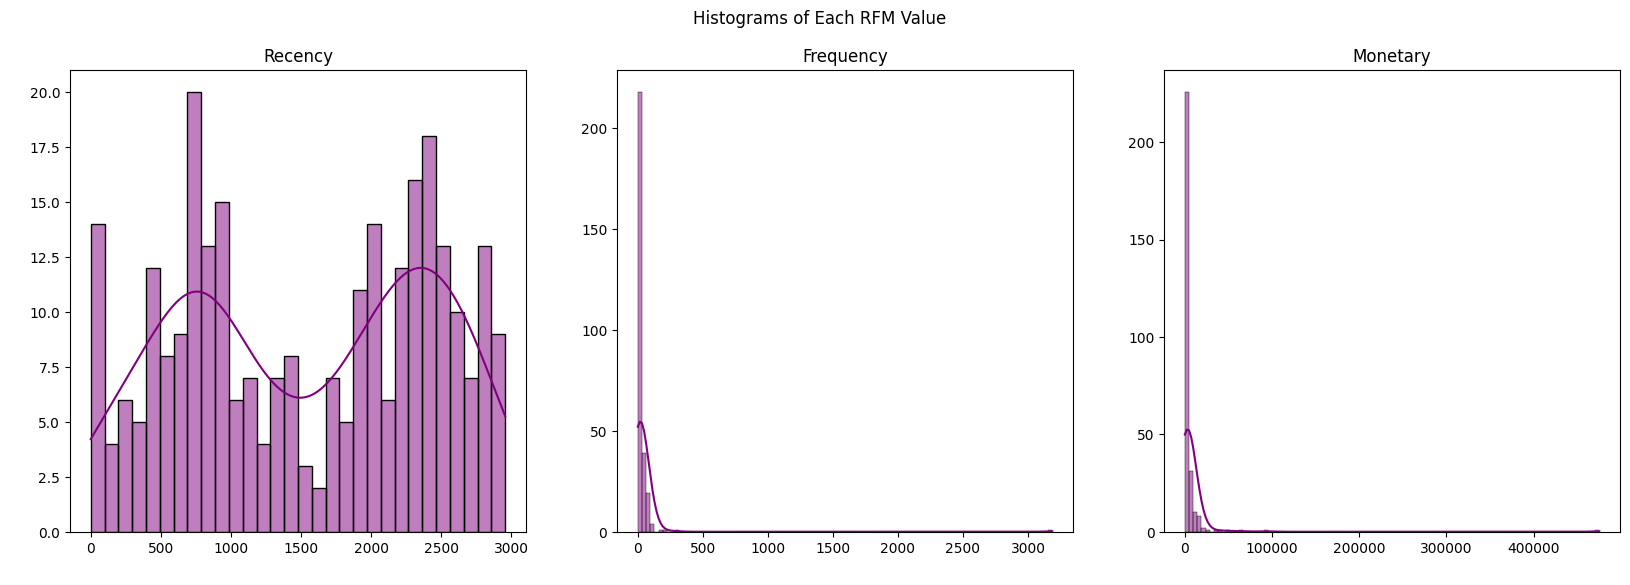

In [43]:
#creating histograms for each attribute
fig, ax = plt.subplots(1,3, figsize=(20,6))
sns.histplot(data=rfm,x="Recency",color="purple",bins=30,kde=True,ax=ax[0])
sns.histplot(data=rfm,x="Frequency",color="purple",bins=100,kde=True,ax=ax[1])
sns.histplot(data=rfm,x="Monetary",color="purple",bins=100,kde=True,ax=ax[2])

cols=rfm.columns[0:3]
i=0

for col in cols:
    ax[i].set_xlabel(" ")
    ax[i].set_ylabel(" ")
    ax[i].set_title(col)

    i=i+1

fig.suptitle("Histograms of Each RFM Value")

As it can be clearly seen that RFM attributes are highly skewed. The log transformation will be used to transform skewed data to approximately conform to normality.

#### **RFM Values Log Transform**

In [44]:
#unskew RFM attributes with log transformations
rfm_log = rfm.apply(np.log, axis = 1).round(2)
rfm_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,7.97,1.95,8.18
12748,6.25,5.28,9.19
12838,7.74,4.08,8.27
12841,7.00,3.85,8.53
12855,5.65,1.10,5.94


To prevent one attribute outweighs the other, let's normalize the data.

#### **RFM Values Normalization**

In [45]:
#scaling RFM attributes
scaler=StandardScaler()
rfm_scale=scaler.fit_transform(rfm_log)

#storing into a dataframe
rfm_scale=pd.DataFrame(rfm_scale,index=rfm_log.index,columns=rfm_log.columns)
rfm_scale.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,0.805038,-0.678427,0.167261
12748,-0.582804,2.220420,1.257400
12838,0.619454,1.175790,0.264402
12841,0.022360,0.975570,0.545032
12855,-1.066934,-1.418372,-2.250474


Text(0.5, 0.98, 'Histograms of Each RFM Value')

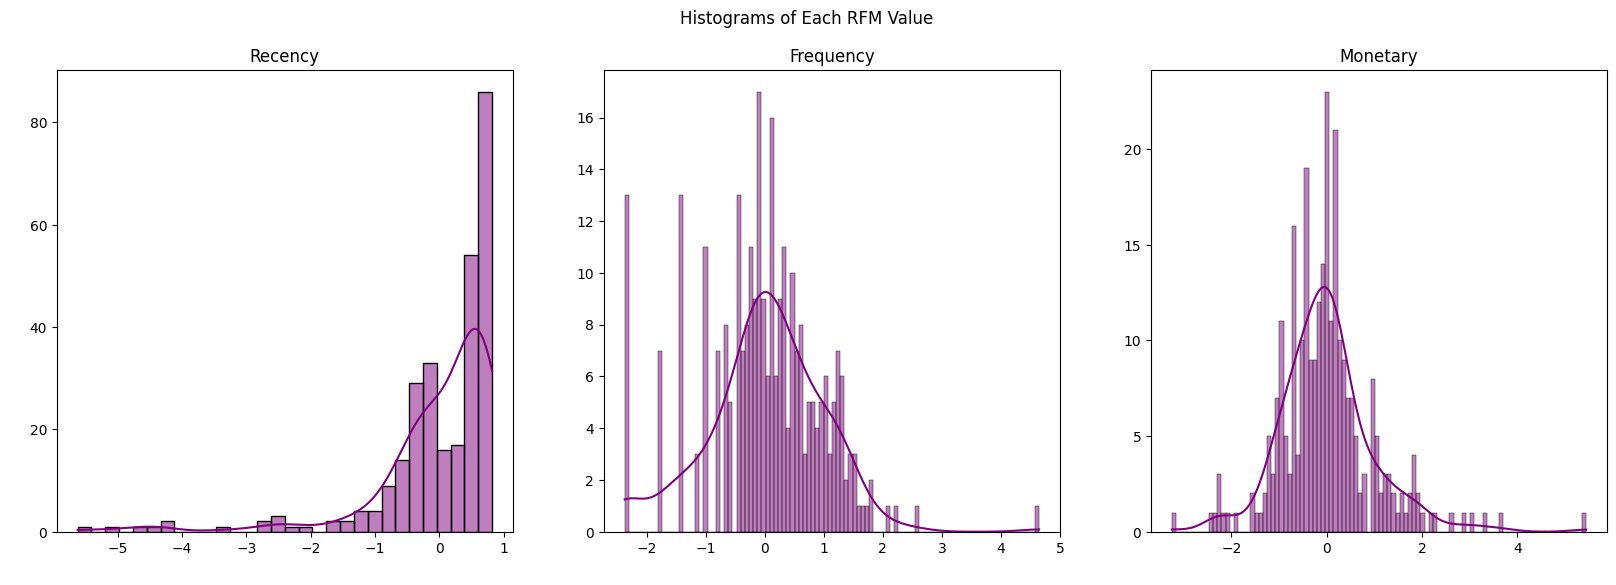

In [46]:
#creating histograms for each attribute
fig, ax = plt.subplots(1,3, figsize=(20,6))
sns.histplot(data=rfm_scale,x="Recency",color="purple",bins=30,kde=True,ax=ax[0])
sns.histplot(data=rfm_scale,x="Frequency",color="purple",bins=100,kde=True,ax=ax[1])
sns.histplot(data=rfm_scale,x="Monetary",color="purple",bins=100,kde=True,ax=ax[2])

cols=rfm.columns[0:3]
i=0

for col in cols:
    ax[i].set_xlabel(" ")
    ax[i].set_ylabel(" ")
    ax[i].set_title(col)

    i=i+1

fig.suptitle("Histograms of Each RFM Value")

By using the log transform method, we get an almost normal distribution in Frequency and Monetary. On the other hand, the distribution of Recency turns into a less-skewed one.

#### **Determining Optimum Number of Clusters**

We will analyze two methods to find the optimum number of clusters and compare the results.

##### **Elbow Method**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

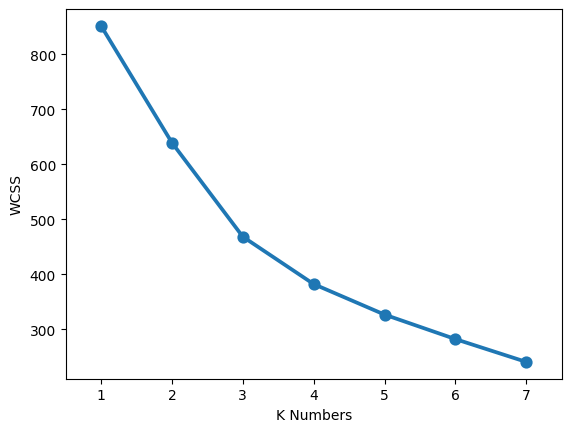

In [47]:
# find the optimum number of clusters (k) using the Elbow method
wcss = {}
for k in range(1, 8):
    kmeans = KMeans(n_clusters= k)
    kmeans.fit(rfm_scale)
    wcss[k] = kmeans.inertia_

# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

##### **Silhouette Method**

In [48]:
# find the optimum number of clusters (k) using the Silhouette method
for n_clusters in range(2,8):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(rfm_scale)
    clusters = kmeans.predict(rfm_scale)
    silhouette_avg = silhouette_score(rfm_scale, clusters)

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.26787150491652245
For n_clusters = 3 The average silhouette_score is : 0.28610839541355626
For n_clusters = 4 The average silhouette_score is : 0.2929913550670761
For n_clusters = 5 The average silhouette_score is : 0.28280483223312725
For n_clusters = 6 The average silhouette_score is : 0.28985545714169386
For n_clusters = 7 The average silhouette_score is : 0.2895679460268446


By considering both methods, k=3 is selected as an optimum cluster number for k-means clustering algorithm.

#### **Customer Segmentation based on K-Means Clusters**

In [49]:
# clustering
clus = KMeans(n_clusters= 3)
clus.fit(rfm_scale)

# assigning the clusters to rfm_segmentation
rfm_segmentation['K_Cluster'] = clus.labels_
rfm_segmentation.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,K_Cluster
CustomerID,,,,,,,,,
12747,2904,7,3585.6,1,1,4,114,6,0
12748,516,196,9756.0,1,4,4,144,9,2
12838,2307,59,3907.9,1,3,4,134,8,2
12841,1101,47,5059.9,1,3,4,134,8,2
12855,285,3,381.0,1,1,2,112,4,0


We are almost done. Now, we will compare RFM Groups and K-Means Clusters.

## **Results**

#### **Visualization of K-Means Clusters**

In [59]:
# joining RFM groups with K-means Clusters
rfm_scale['K_Cluster'] = clus.labels_
rfm_scale['RFM_Group'] = rfm_segmentation.RFM_Group
rfm_scale.reset_index(inplace = True)
rfm_scale.head()

,CustomerID,Recency,Frequency,Monetary,K_Cluster,RFM_Group
0,12747,0.805038,-0.678427,0.167261,0,At_risk
1,12748,-0.582804,2.220420,1.257400,2,High_value
2,12838,0.619454,1.175790,0.264402,2,Loyal
3,12841,0.022360,0.975570,0.545032,2,Loyal
4,12855,-1.066934,-1.418372,-2.250474,0,Lost


Text(0.5, 0.98, 'Scatter Plots of K-Means Clusters')

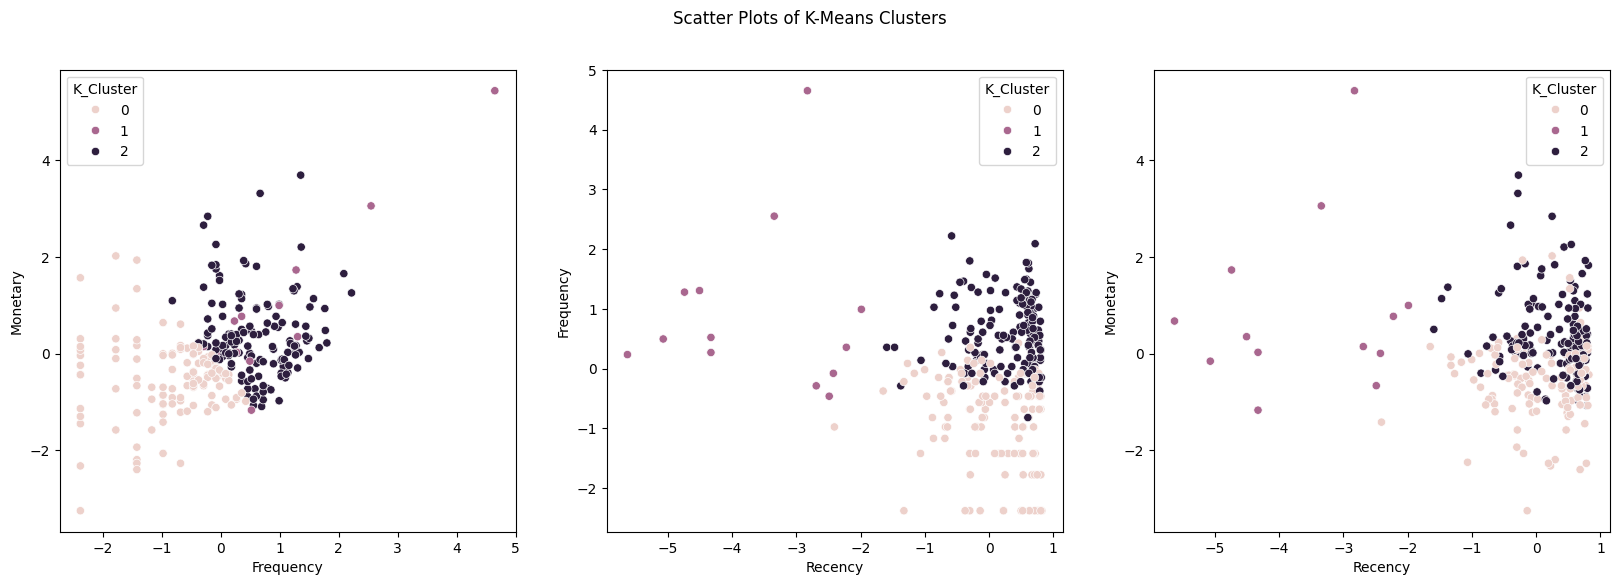

In [60]:
# visualizing K Clusters with RFM Values
fig, ax = plt.subplots(1,3, figsize=(20,6))
sns.scatterplot(x = rfm_scale["Frequency"], y = rfm_scale["Monetary"], hue = rfm_scale["K_Cluster"],ax=ax[0])
sns.scatterplot(x = rfm_scale["Recency"], y = rfm_scale["Frequency"], hue = rfm_scale["K_Cluster"],ax=ax[1])
sns.scatterplot(x = rfm_scale["Recency"], y = rfm_scale["Monetary"], hue = rfm_scale["K_Cluster"],ax=ax[2])
fig.suptitle("Scatter Plots of K-Means Clusters")

#### **Visualization of RFM Groups**

Text(0.5, 0.98, 'Scatter Plots of RFM Groups')

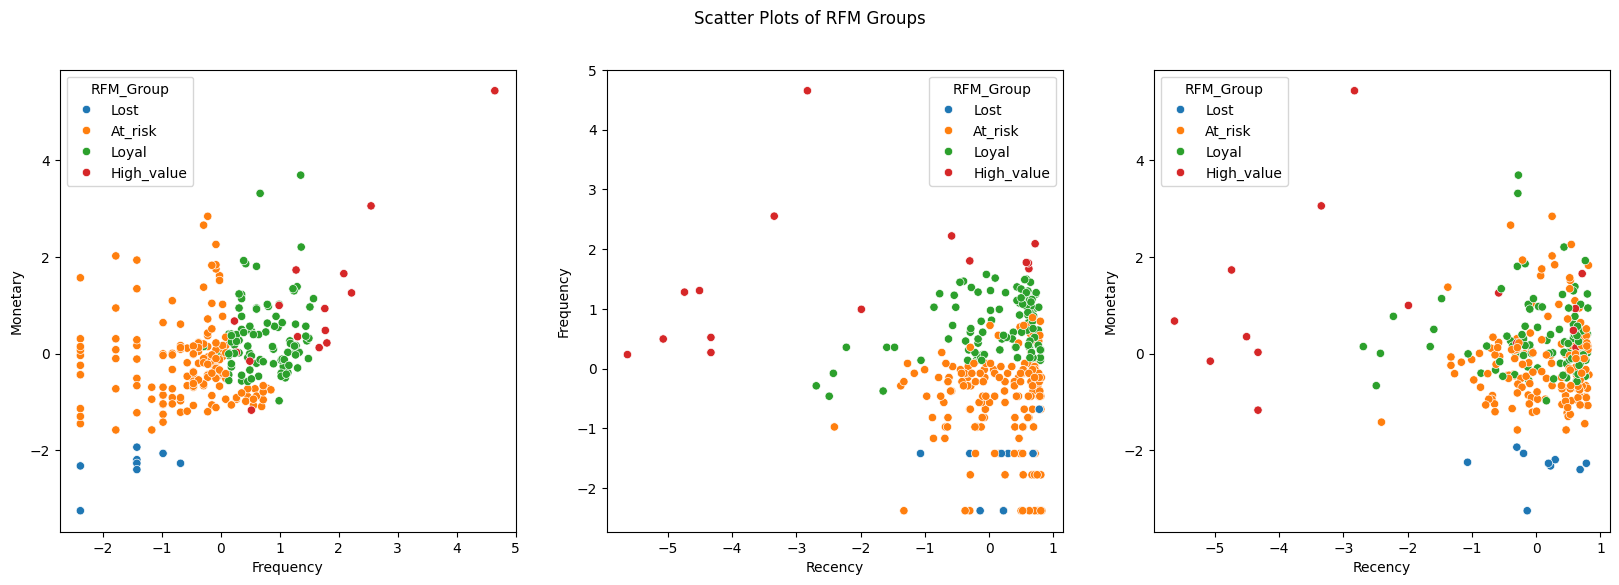

In [61]:
# visualizing RFM Groups across RFM Values
fig, ax = plt.subplots(1,3, figsize=(20,6))
sns.scatterplot(x = rfm_scale["Frequency"], y = rfm_scale["Monetary"], hue = rfm_scale["RFM_Group"],ax=ax[0])
sns.scatterplot(x = rfm_scale["Recency"], y = rfm_scale["Frequency"], hue = rfm_scale["RFM_Group"],ax=ax[1])
sns.scatterplot(x = rfm_scale["Recency"], y = rfm_scale["Monetary"], hue = rfm_scale["RFM_Group"],ax=ax[2])
fig.suptitle("Scatter Plots of RFM Groups")

When comparing RFM groups and K-Means Clusters, we can clearly see that 3 K-Means Clusters are more distinctive. It is better to run marketing campaigns with 3 clusters and we can also take a look at a 3D scatter plot of RFM values with 3 K-clusters to get a better picture.

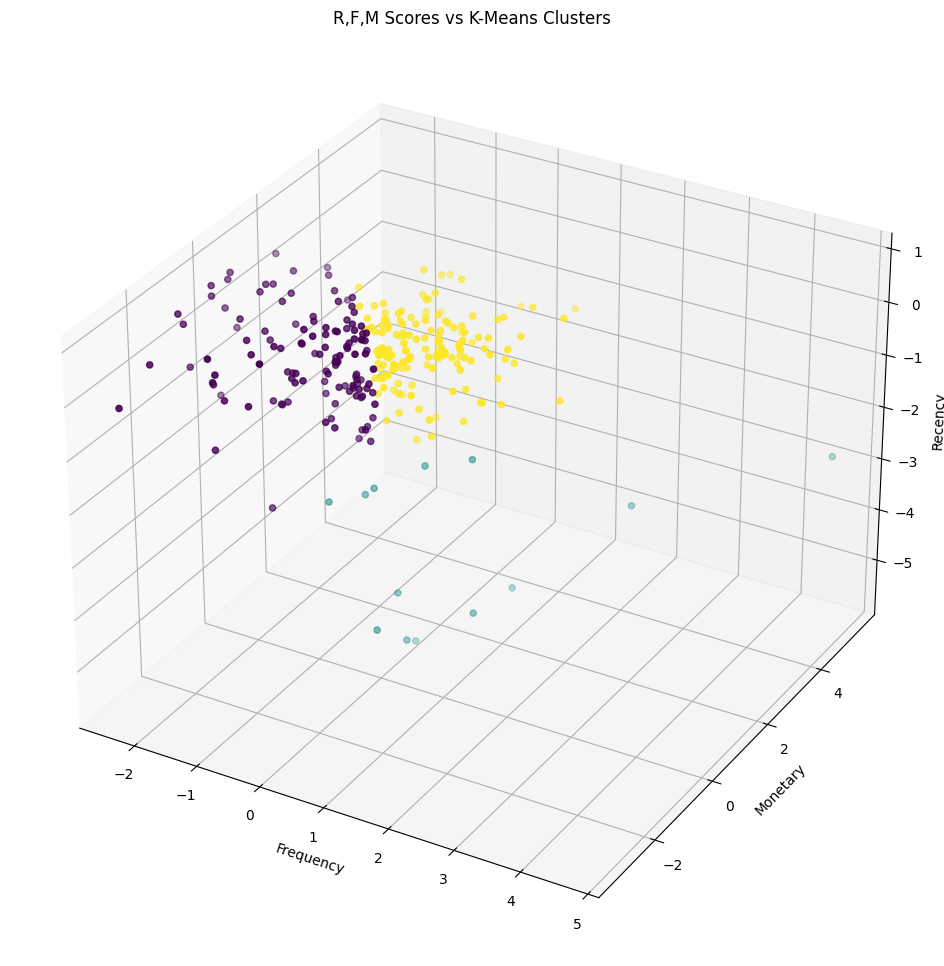

In [62]:
# 3D scatter plot of R, F & M values with the 3 K_Clusters
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_scale["Frequency"], rfm_scale["Monetary"], rfm_scale["Recency"], c = rfm_scale["K_Cluster"])
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")
ax.set_title("R,F,M Scores vs K-Means Clusters")

plt.show()

Finally, we have 3 different clusters!

## **Conclusion**

- Cluster 2 represents the high-value customers, characterized by the highest number of orders, frequency, and the most recent transactions.
- Cluster 1 consists of lost customers who rarely place orders and generate the lowest sales.
- Cluster 0 includes at-risk and loyal customers, who exhibit medium values in terms of frequency, recency, and monetary metrics.
- Across all clusters, high monetary value is associated with a high frequency of orders and more recent transactions.

## **Recommendations**

The company can design targeted marketing campaigns for various customer segments to boost revenue. To achieve this, the company might provide incentives to low-value customers to maintain their engagement and encourage more frequent purchases. Conversely, high-value customers could receive special benefits, such as exclusive discounts and early access to new products. As conclusion, the approach will depend on the company's specific business objectives.<br>